**RNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')
data_vals = data.values


<ipython-input-18-75368f300ee2>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


**Create models and results**

In [ ]:
# Define the scheduler function
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Normalize the data (apply MinMaxScaler across all features)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_vals)

# Define sequence length and lag (the number of days to predict forward based on sequence length)
sequence_length = 100
lags = [1,5,10,20,30] # Prediction horizons. Use 1 value for one model creation and evaluation
y_tests = []
preds = []
rmses = []

for lag in lags:
  # Prepare input (X) and output (Y) sequences
  X, Y = [], []
  for i in range(len(data_normalized) - sequence_length-lag):
      X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
      Y.append(data_normalized[i + sequence_length + lag, 3])    # Output (Using close at index 3)

  X = np.array(X)
  Y = np.array(Y)


  # Split the data into training and testing sets
  split_ratio = 0.8
  split_index = int(split_ratio * len(X))
  X_train, X_test = X[:split_index], X[split_index:]
  Y_train, Y_test = Y[:split_index], Y[split_index:]

  # Create the callback
  lr_scheduler = LearningRateScheduler(step_decay)

  # Build the RNN model for multivariate input and univariate output
  model = Sequential([
        SimpleRNN(units=80, return_sequences=False, input_shape=(sequence_length, X.shape[2])),
        Dense(units=1)
    ])


  model.summary()
  plot_model(model, to_file="simple_rnn_model.png", show_shapes=True, show_layer_names=True)
  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1, callbacks=[lr_scheduler])

  # Predict on the test set
  predictions = model.predict(X_test)

  # Inverse scale predictions and actual values for evaluation
  min_val = scaler.data_min_[3]  # Minimum value of feature 3
  max_val = scaler.data_max_[3]  # Maximum value of feature 3

  # Denormalize the predictions
  predictions_rescaled = predictions * (max_val - min_val) + min_val
  Y_test_rescaled = Y_test * (max_val - min_val) + min_val

  # Evaluate the model using Root Mean Squared Error (RMSE) for the fourth variable 'Close'
  rmse = np.sqrt(mean_squared_error(Y_test_rescaled, predictions_rescaled))
  print(f"Root Mean Squared Error: {rmse}")


  y_tests.append(Y_test_rescaled)
  preds.append(predictions_rescaled)
  rmses.append(rmse)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_29 (SimpleRNN)            │ (None, 80)                  │           6,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1389 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.0150e-04 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0158e-04 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1778e-04 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4669e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8102e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9897e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9908e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2292e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.6380e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_30 (SimpleRNN)            │ (None, 80)                  │           6,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3862 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0122 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.8536e-04 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3219e-04 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3588e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8863e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3471e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9627e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3798e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9981e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9907e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_31 (SimpleRNN)            │ (None, 80)                  │           6,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2057 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.8865e-04 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0039e-04 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1409e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1423e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4402e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2305e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3101e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2069e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5337e

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_32 (SimpleRNN)            │ (None, 80)                  │           6,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2026 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0054 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.0040e-04 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2017e-04 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2003e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4539e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.3277e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.8305e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.0465e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7939e-04 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_33 (SimpleRNN)            │ (None, 80)                  │           6,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5047 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0313 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - learning_rate: 0.0050
Epoch 12

**Plot**

Predictions 1 days forward rmse: 28.749650420534476
Predictions 5 days forward rmse: 45.994622627882414
Predictions 10 days forward rmse: 53.127301875633826
Predictions 20 days forward rmse: 58.31978539677506
Predictions 30 days forward rmse: 64.28876898665847


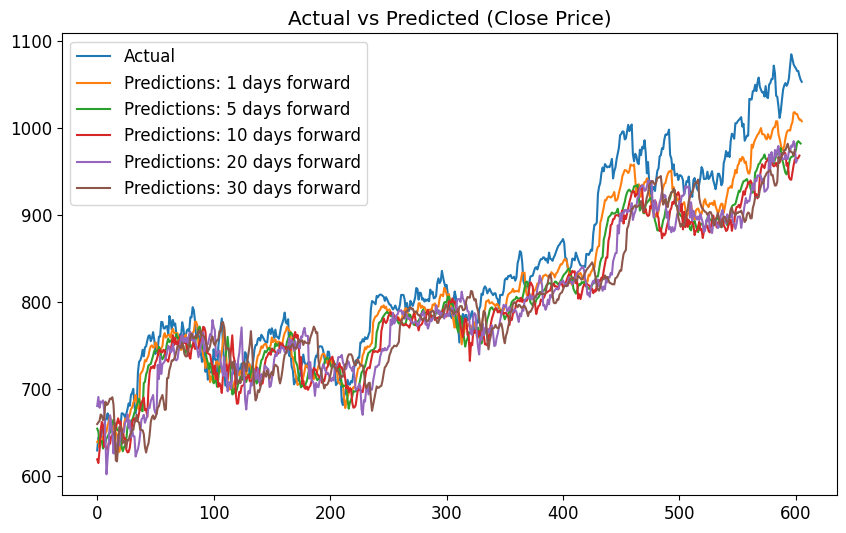

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(y_tests[0], label='Actual')

for i in range(len(preds)):
  plt.plot(preds[i], label='Predictions: '+ str(lags[i]) + ' days forward')
  print('Predictions ' + str(lags[i]) + ' days forward rmse: ' + str(rmses[i]))

plt.legend()
plt.title("Actual vs Predicted (Close Price)")
plt.savefig("RNN_preds.png")
plt.show()
